In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# np.random.seed(123)
sns.set_style("whitegrid")

In [2]:
# Bigger font
sns.set_context("poster")
# Figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4
plt.rc('figure.subplot', wspace=.33)

EDA

- Understand the data
- Build intuition about the data
- Generate hypotheses
- Find insights
- Find "Data Leaks" (mistakes by the organizers)
- Have a 80%+ accuracy w/o even running a classifier

When will EDA not help?

- When data is anonymized
- Encrypted
- Pre-processed

Even so, one needs EDA to realize that this is the case.

## EDA

### Approach 1: Aggressive Modeling

1. Read the data
2. Fit it with a predictor doing MIXING, STACKING (ensemble learning)

### Approach 2: EDA

After getting domain knowledge of the task, what do we do during EDA?

#### a. Visualization

- See patterns
- Build a model using those patterns

There are 2 things to do with visualization

- Find patterns that lead to questions: Visualization -> Idea
- Hypothesis testing: Idea -> Visualization

#### b. Check if data is intuitive

Example

- "Age of 336" would be a typo or our misinterpretation.
- "#clicks > #impressions" -----> make a new column "is_incorrect"

![](images/data-ads.jpg)

#### c. Check how the data (test and train data) was generated

- Important to set up a proper validation scheme
- TRAIN and TEST set could have been generated by different algorithms. If that happens, we cannot use part of TRAIN as validation because it doesn't represent the TEST

## EDA on Anonymized Data

- Organizers may not want some information to be seen. They decode them but all the features are preserved.

Document encoding (hashed words)

![](images/anonymized1.jpg)

Encoded columns

![](images/anonymized2.jpg)

What to do?

- Try to decode the data
    - Explore individual features: Guess meaning and types of the columns
    - Explore feature relations: Find relations between pairs and feature groups


### a. Guessing meaning

In [3]:
train = pd.read_csv('data/train.csv.gz')
train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,y
0,b4d8a653ea,16a14a2d17,06330986ed,ca63304de0,a62168d626,1746600cb0,1,1,-0.688706,7e5c97705a,...,0.235333,0.264952,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,9.0,2
1,467f9617a3,16a14a2d17,06330986ed,ca63304de0,b7584c2d52,1746600cb0,1,1,0.870871,5624b8f759,...,1.782346,1.322409,0.011647,0.397671,0.239601,0.249584,0.068220,0.033278,601.0,4
2,190436e528,16a14a2d17,06330986ed,ca63304de0,b7584c2d52,1746600cb0,1,1,0.437655,5624b8f759,...,-0.586540,0.672436,0.000000,0.606061,0.121212,0.212121,0.060606,0.000000,33.0,3
3,43859085bc,16a14a2d17,06330986ed,ca63304de0,a62168d626,1746600cb0,1,1,0.004439,f67f142e40,...,-1.600326,-1.838680,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,4
4,a4c3095b75,16a14a2d17,06330986ed,ca63304de0,b7584c2d52,1746600cb0,1,1,0.480977,7e5c97705a,...,0.960991,0.790990,0.020161,0.645161,0.258065,0.036290,0.040323,0.000000,248.0,3


Check what's the most important feature

In [4]:
X = train.copy()
y = train.y
X = X.drop('y', axis=1)
X = X.fillna(-999)
for c in train.columns[train.dtypes == 'object']:
    X[c] = X[c].factorize()[0]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

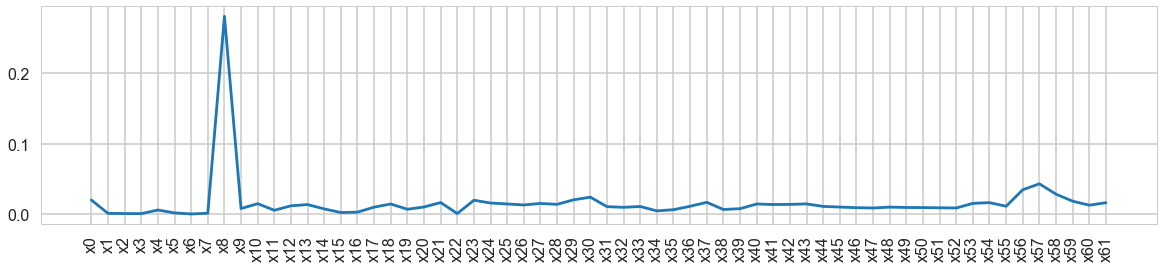

In [5]:
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

#### Analizing x8

It was standardized!

In [6]:
print('Mean:', train.x8.mean())
print('std:', train.x8.std())

Mean: -0.0002523520286219452
std: 1.0232816360125667


So the point is to revert that scaling procedure to see what these column is really about.  
Here's a nice explanation of how to do it
https://www.coursera.org/learn/competitive-data-science/lecture/qJHOb/exploring-anonymized-data

### b. Guessing types

- A feature can be categorical, numeric (float, event counters), text, binary.
- If the number of columns is small, print the table and guess types.

## Helpful functions

In [7]:
train.iloc[:,range(10)].dtypes

x0     object
x1     object
x2     object
x3     object
x4     object
x5     object
x6      int64
x7      int64
x8    float64
x9     object
dtype: object

In [8]:
train.iloc[:,range(10)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
x0    49480 non-null object
x1    49500 non-null object
x2    49528 non-null object
x3    49504 non-null object
x4    49514 non-null object
x5    49490 non-null object
x6    50000 non-null int64
x7    50000 non-null int64
x8    48793 non-null float64
x9    47642 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 3.8+ MB


In [9]:
train.iloc[:,range(10)].iloc[:,9].value_counts()

f67f142e40    16313
5624b8f759     7189
fc150fd13a     6844
7e5c97705a     6366
7b1f0ca4c1     5527
4cf172e00e     3113
60e078bf05     2290
Name: x9, dtype: int64

In [10]:
train.iloc[:,range(10)].iloc[:,9].isnull()

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
49970    False
49971    False
49972    False
49973    False
49974    False
49975    False
49976    False
49977    False
49978    False
49979    False
49980    False
49981    False
49982    False
49983    False
49984    False
49985     True
49986    False
49987    False
49988    False
49989     True
49990    False
49991    False
49992    False
49993    False
49994    False
49995    False
49996    False
49997    False
49998    False
49999    False
Name: x9, Length: 50000, dtype: bool